<img src="images/dask_horizontal.svg" align="left" width="30%">

# Dask Arrays with Xarray


<img src="images/Dask Array (Light).png" width="50%" align="right">
Dask array provides a parallel, larger-than-memory, n-dimensional array using blocked algorithms. Simply put: distributed Numpy.

*  **Parallel**: Uses all of the cores on your computer
*  **Larger-than-memory**:  Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
*  **Blocked Algorithms**:  Perform large computations by performing many smaller computations

This notebook **also demonstrates** one of xarray's most powerful features: the ability to wrap dask arrays and allow users to seamlessly execute analysis code in parallel.


## Learning Objectives

- Understand key features of dask arrays
- Work with Dask Array's in much the same way you would work with a NumPy array
- Learn that xarray DataArrays and Datasets are "dask collections" i.e. you can execute top-level dask functions such as dask.visualize(xarray_object)
- Learn that all xarray built-in operations can transparently use dask

## Prerequisites


| Concepts | Importance | Notes |
| --- | --- | --- |
| Familiarity with NumPy | Necessary | |
| Familiarity with Xarray | Necessary | |


- **Time to learn**: *30-40 minutes*


## Imports

In [1]:
import dask
import dask.array as da
import numpy as np
import xarray as xr
from dask.distributed import Client, LocalCluster
from distributed.utils import format_bytes
from pythia_datasets import DATASETS

/var/folders/bw/c9j8z20x45s2y20vv6528qjc0000gq/T/ipykernel_41384/3678927887.py:6: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes


## Setup
We first need to spin up a **Cluster** which is a tool which enable us to work in a **parallel** and **distributed** workflow.

In [2]:
cluster = LocalCluster()
client = Client(cluster)
client

2022-09-26 11:14:17,667 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/mgrover/git_repos/pythia-foundations/core/xarray/dask-worker-space/worker-ugxn97qa', purging
2022-09-26 11:14:17,667 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/mgrover/git_repos/pythia-foundations/core/xarray/dask-worker-space/worker-9ky9z6dp', purging
2022-09-26 11:14:17,667 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/mgrover/git_repos/pythia-foundations/core/xarray/dask-worker-space/worker-xstnr0xb', purging
2022-09-26 11:14:17,667 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/mgrover/git_repos/pythia-foundations/core/xarray/dask-worker-space/worker-g_uv3xc3', purging
2022-09-26 11:14:17,667 - distributed.diskutils - INFO - Found stale lock file and directory '/Users/mgrover/git_repos/pythia-foundations/core/xarray/dask-worker-space/worker-0bhms48l', purging


<Client: 'tcp://127.0.0.1:52183' processes=5 threads=10, memory=32.00 GiB>

## Blocked Algorithms

A *blocked algorithm* executes on a large dataset by breaking it up into many small blocks.

For example, consider taking the sum of a billion numbers.  We might instead break up the array into 1,000 chunks, each of size 1,000,000, take the sum of each chunk, and then take the sum of the intermediate sums.

We achieve the intended result (one sum on one billion numbers) by performing many smaller results (one thousand sums on one million numbers each, followed by another sum of a thousand numbers.)

### `dask.array` contains these algorithms

`dask.array` implements a subset of the NumPy ndarray interface using blocked algorithms, cutting up the large array into many small arrays. This lets us compute on arrays larger than memory using multiple cores. We coordinate these blocked algorithms using Dask graphs. Dask Array's are also lazy, meaning that they do not evaluate until you explicitly ask for a result using the compute method.

### Create `dask.array` object

If we want to create a 3D NumPy array of random values, we do it like this:

In [3]:
shape = (600, 200, 200)
arr = np.random.random(shape)
arr

array([[[0.65628401, 0.49523391, 0.11106995, ..., 0.47995951,
         0.17656552, 0.20448031],
        [0.12100478, 0.43936589, 0.81654412, ..., 0.1937781 ,
         0.08365122, 0.69969926],
        [0.30701696, 0.25221372, 0.15790117, ..., 0.28538596,
         0.95907629, 0.13950318],
        ...,
        [0.83063749, 0.81095374, 0.29230465, ..., 0.19220911,
         0.69613306, 0.98267604],
        [0.43373802, 0.230833  , 0.38004739, ..., 0.67248016,
         0.2374586 , 0.74990848],
        [0.2793906 , 0.66489515, 0.79329903, ..., 0.21312733,
         0.74342239, 0.62177718]],

       [[0.88250214, 0.48351952, 0.39723815, ..., 0.15282229,
         0.92259681, 0.60787583],
        [0.72076721, 0.82176659, 0.28149094, ..., 0.29367928,
         0.32023359, 0.67819095],
        [0.5568043 , 0.18733137, 0.80377662, ..., 0.85800289,
         0.63105948, 0.56576797],
        ...,
        [0.42143109, 0.13531766, 0.25317434, ..., 0.49683358,
         0.26613785, 0.55376068],
        [0.5

In [4]:
format_bytes(arr.nbytes)

'183.11 MiB'

This array contains `~183 MB` of data

Now let's create the same array using Dask's array interface.

In [5]:
darr = da.random.random(shape, chunks=(300, 100, 200))

A chunk size to tell us how to block up our array, like `(300, 100, 200)`. 

<div class="admonition alert alert-info">
    <p class="admonition-title" style="font-weight:bold">Specifying Chunks</p>
    There are <a href="https://docs.dask.org/en/latest/array-chunks.html">several ways to specify chunks</a>. In this tutorial, we will use a block shape.


</div>



In [6]:
darr

dask.array<random_sample, shape=(600, 200, 200), dtype=float64, chunksize=(300, 100, 200), chunktype=numpy.ndarray>

Notice that we just see a symbolic representation of the array, including its `shape`, `dtype`, and `chunksize`. No data has been generated yet. Let's visualize the constructed task graph. 

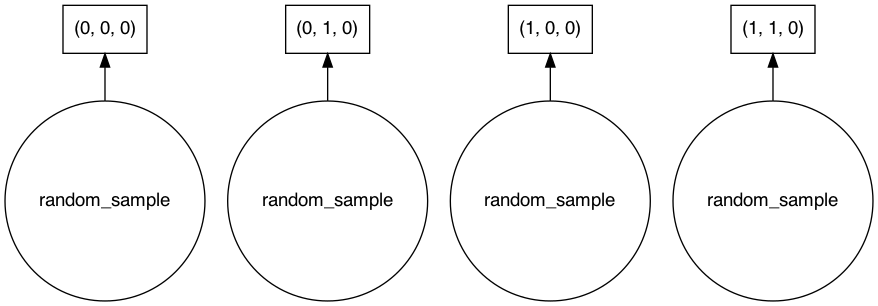

In [7]:
darr.visualize()

Our array has four chunks. To generate it, Dask calls `np.random.random` four times and then concatenates this together into one array.

### Manipulate `dask.array` object as you would a numpy array


Now that we have an `Array` we perform standard numpy-style computations like arithmetic, mathematics, slicing, reductions, etc..

The interface is familiar, but the actual work is different. `dask_array.sum()` does not do the same thing as `numpy_array.sum()`.

#### What's the difference?

`dask_array.sum()` builds an expression of the computation. It does not do the computation yet. `numpy_array.sum()` computes the sum immediately.

#### Why the difference?

Dask arrays are split into chunks. Each chunk must have computations run on that chunk explicitly. If the desired answer comes from a small slice of the entire dataset, running the computation over all data would be wasteful of CPU and memory.

In [8]:
total = darr.sum()
total

dask.array<sum-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

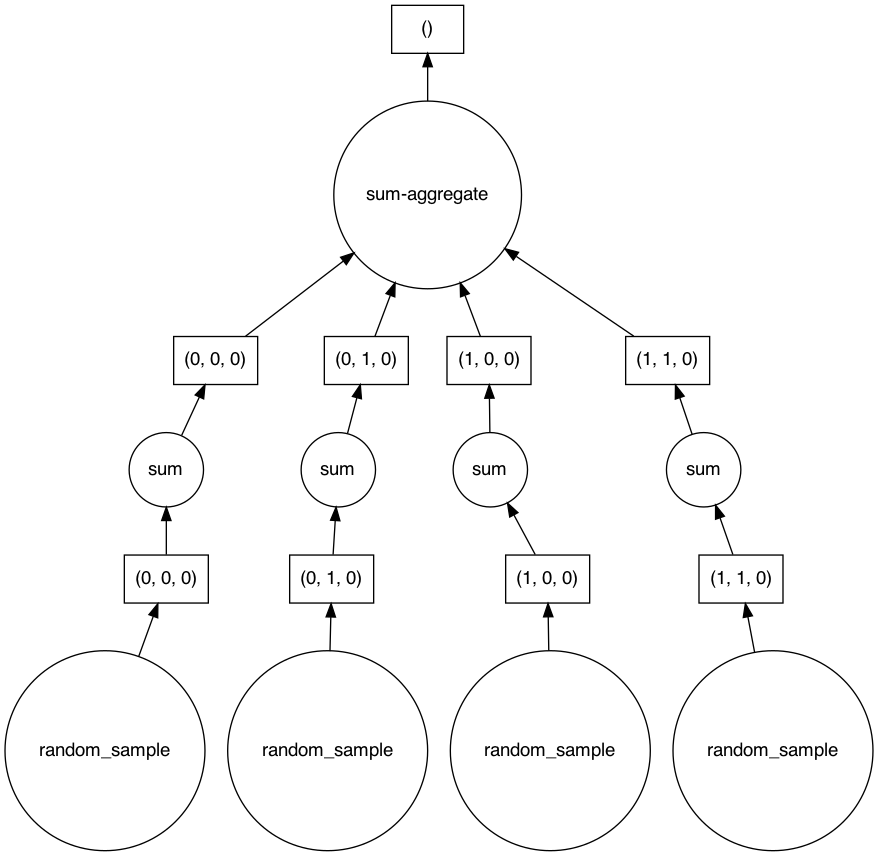

In [9]:
total.visualize()

#### Compute result

Dask.array objects are lazily evaluated.  Operations like `.sum` build up a graph of blocked tasks to execute.  

We ask for the final result with a call to `.compute()`.  This triggers the actual computation.

In [10]:
%%time
total.compute()

CPU times: user 80.8 ms, sys: 53.8 ms, total: 135 ms
Wall time: 254 ms


12001278.237365684

### Exercise: Modify the chunk size (or shape) in the random dask array, call `.sum()` on the new array, and visualize how the task graph changes.

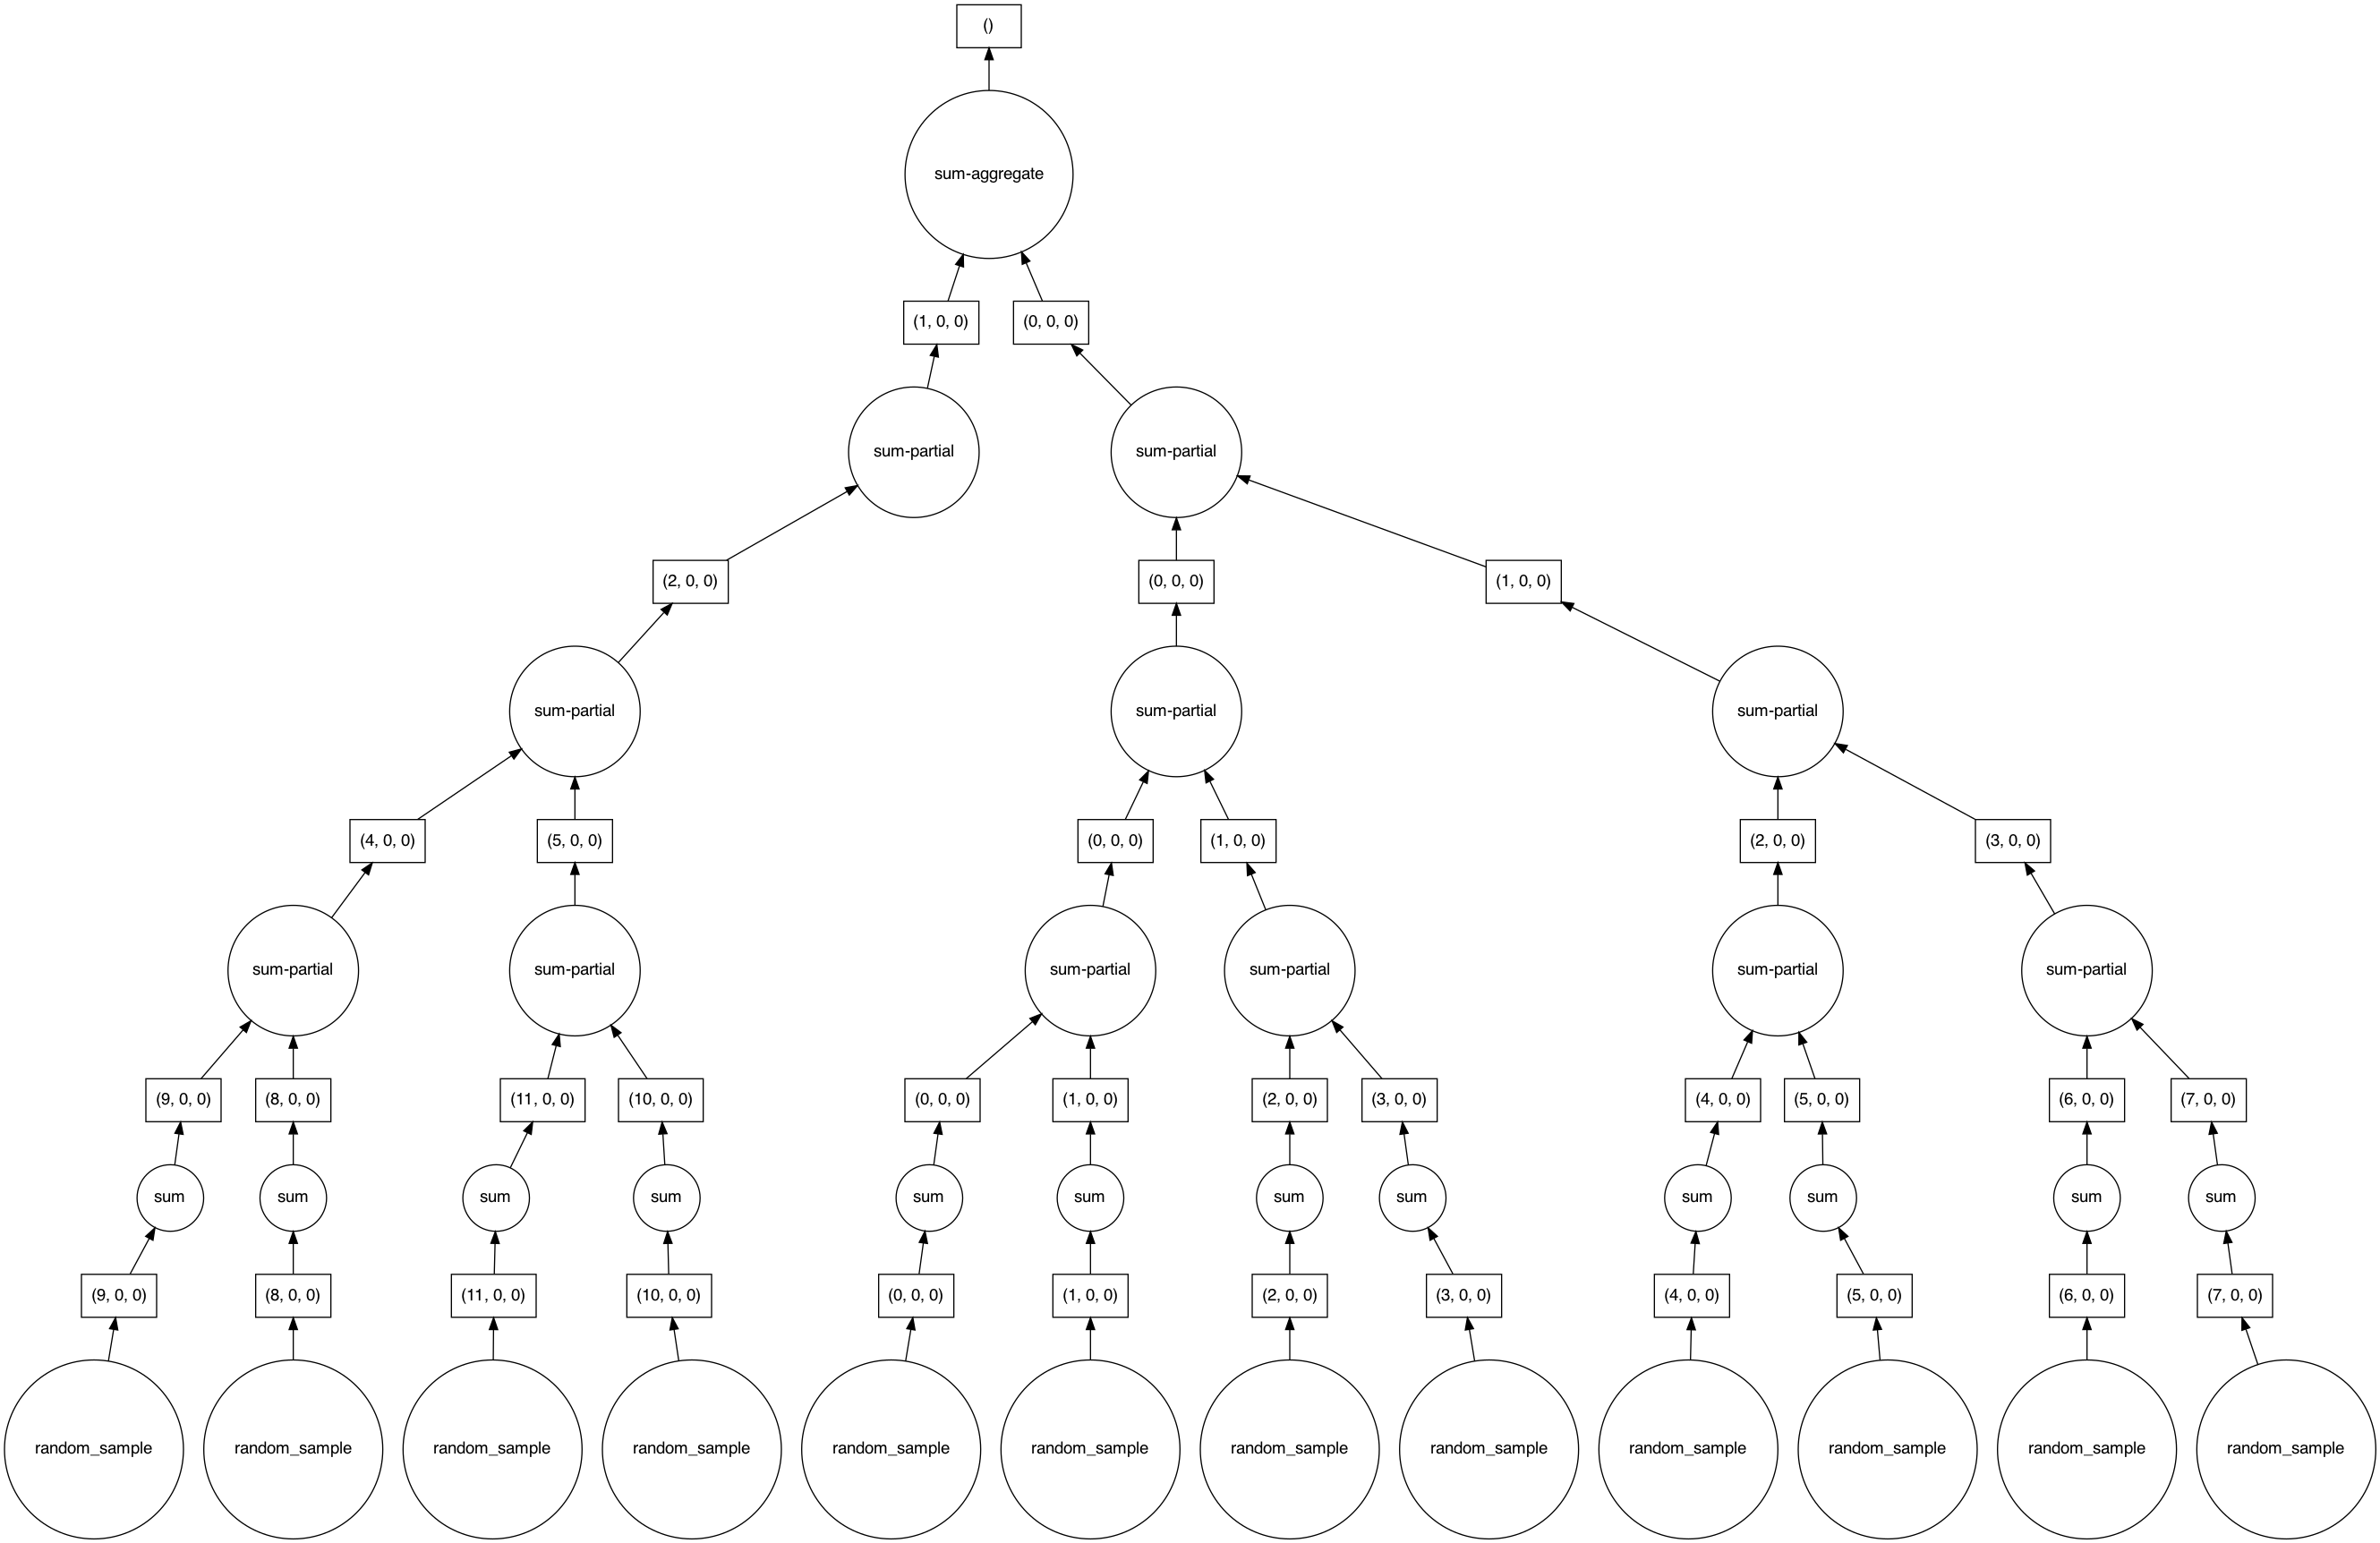

In [11]:
da.random.random(shape, chunks=(50, 200, 400)).sum().visualize()

Here we see Dask's strategy for finding the sum. This simple example illustrates the beauty of Dask: it automatically designs an algorithm appropriate for custom operations with big data.

If we make our operation more complex, the graph gets more complex:

In [12]:
z = darr.dot(darr.T).mean(axis=0)[::2, :].std(axis=1)
z

dask.array<_sqrt, shape=(100, 600), dtype=float64, chunksize=(50, 300), chunktype=numpy.ndarray>

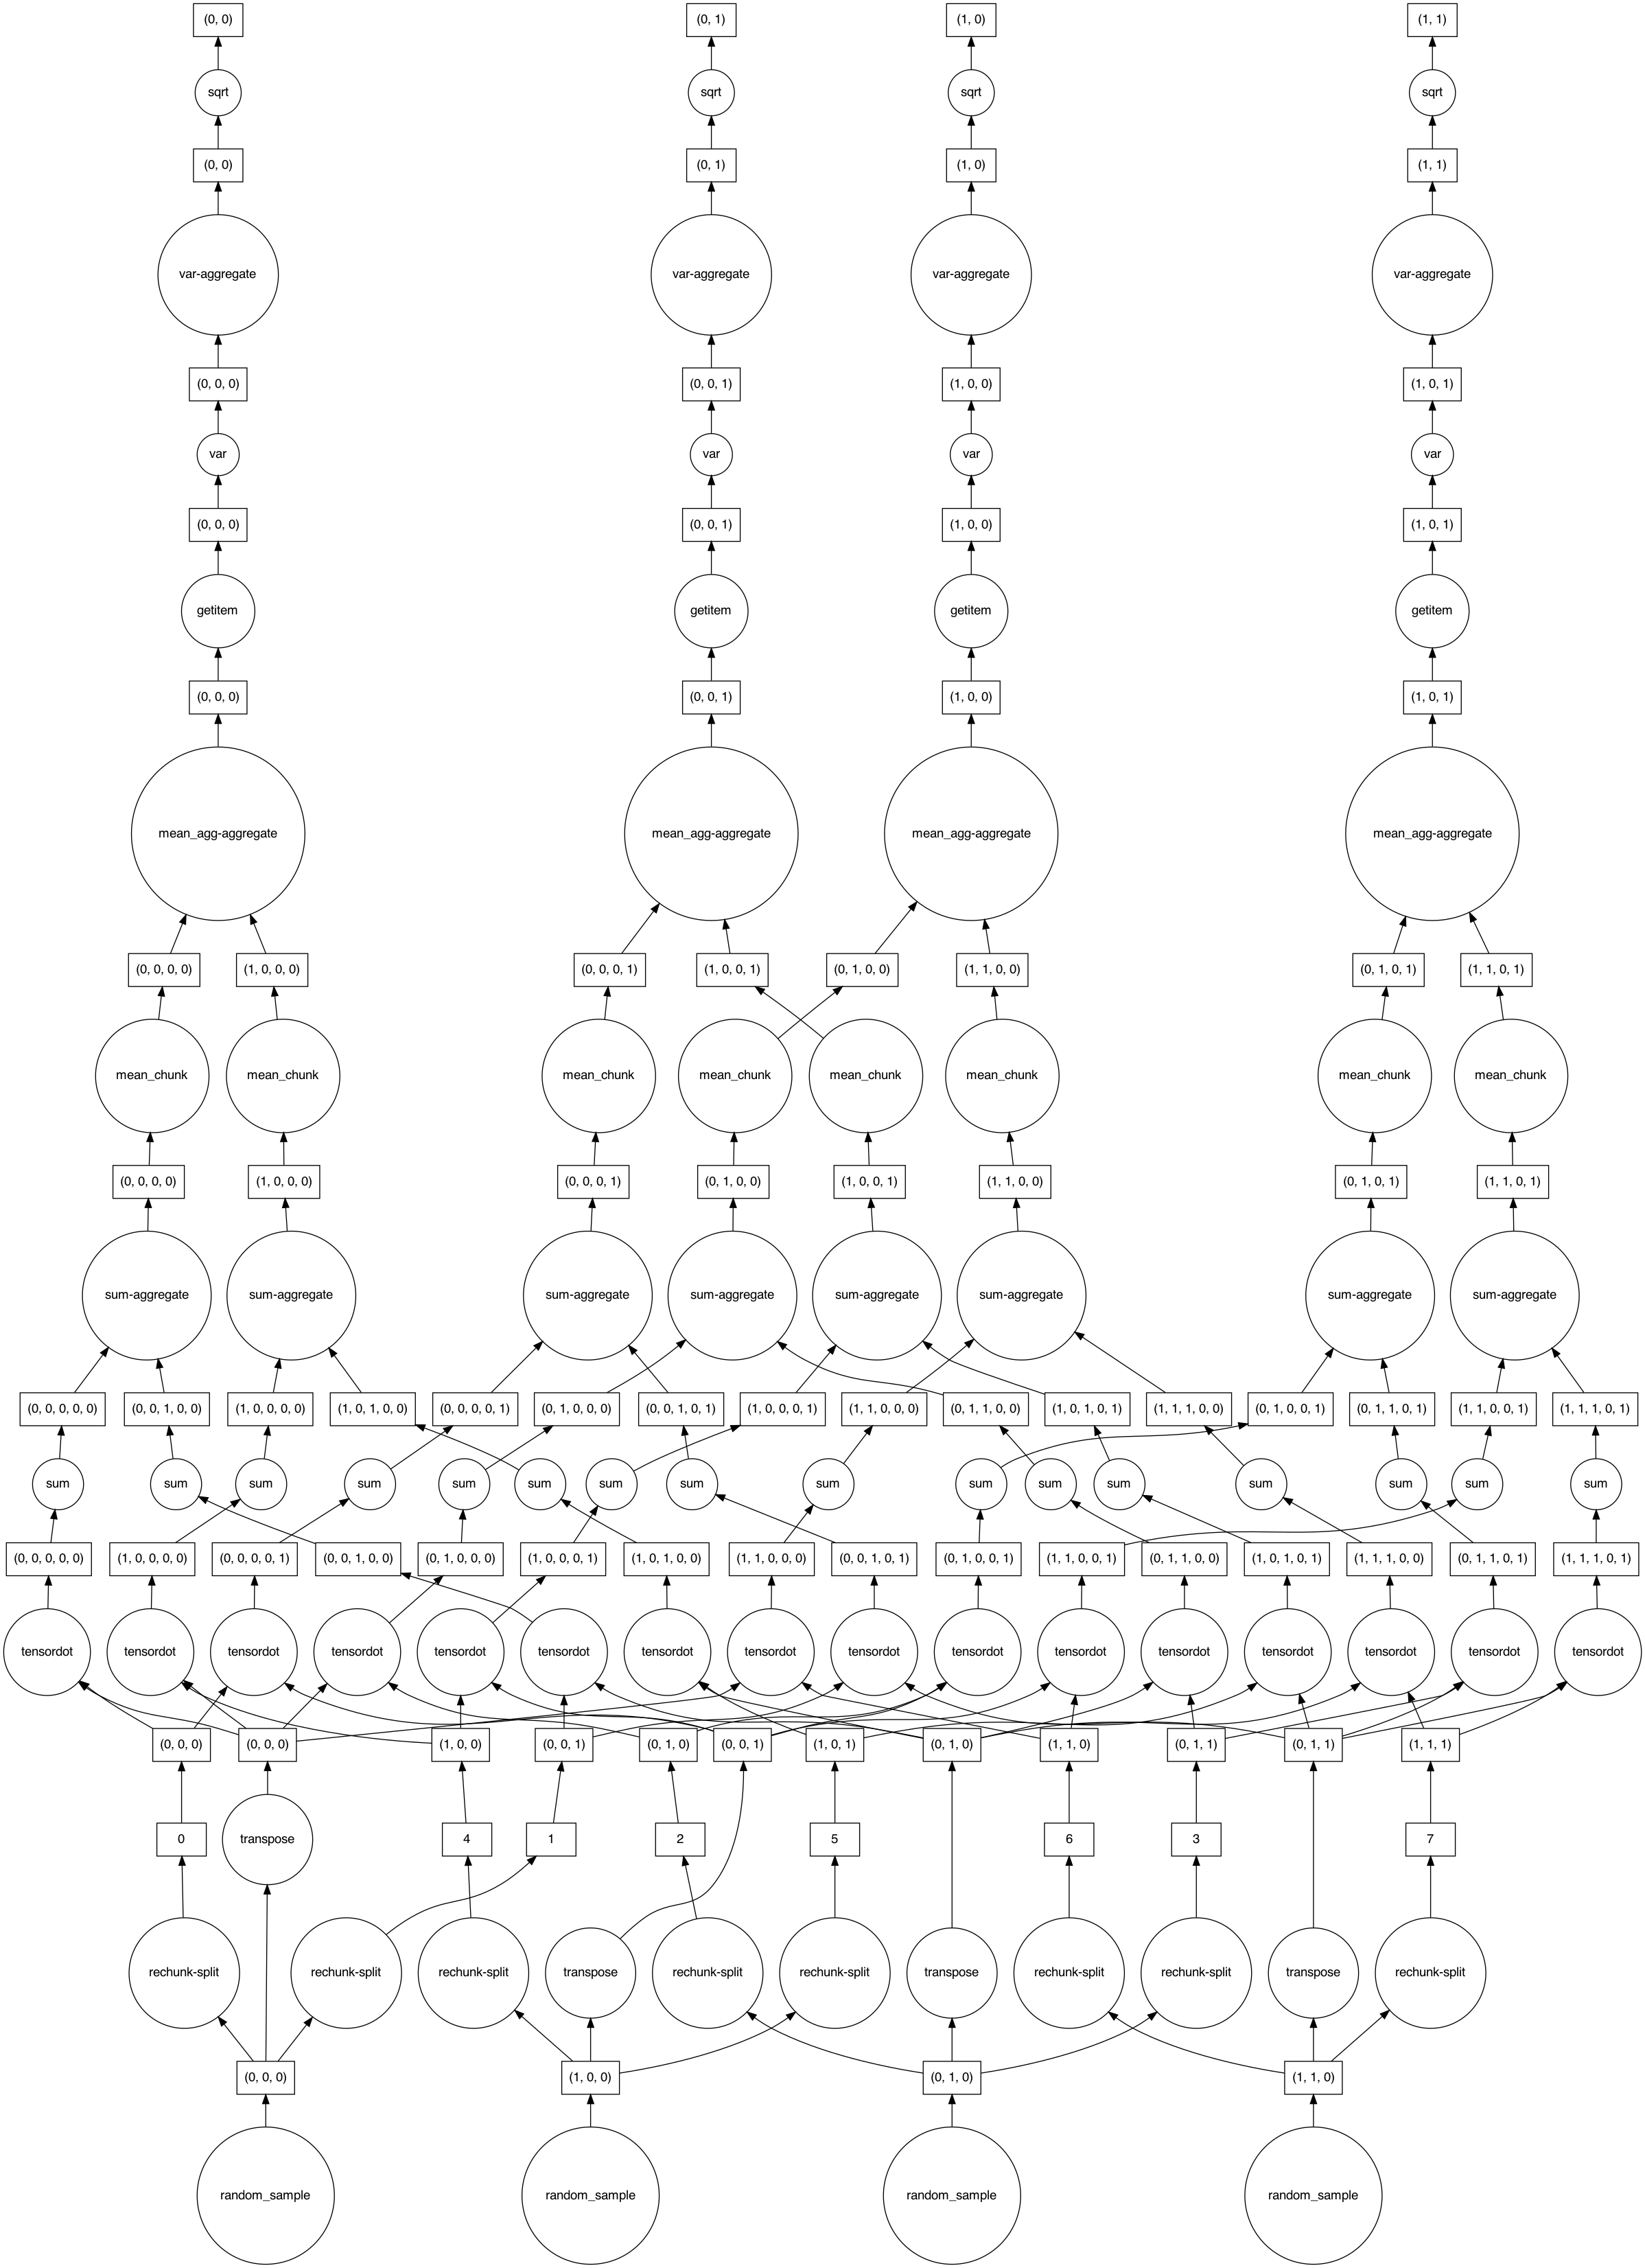

In [ ]:
z.visualize()

### A Bigger Calculation

The examples above were toy examples; the data (180 MB) is probably not big enough to warrant the use of Dask.

We can make it a lot bigger! Let's create a new, big array

In [25]:
darr = da.random.random((4000, 100, 4000), chunks=(1000, 100, 500)).astype('float32')
darr

dask.array<astype, shape=(4000, 100, 4000), dtype=float32, chunksize=(1000, 100, 500), chunktype=numpy.ndarray>

This dataset is `~6 GB`, rather than 32 MB! This is probably close to or greater than the amount of available RAM than you have in your computer. Nevertheless, Dask has no problem working on it.

In [26]:
z = (darr + darr.T)[::2, :].mean(axis=2)

In [27]:
z.visualize()

In [28]:
%%time
z.compute()

CPU times: user 589 ms, sys: 162 ms, total: 751 ms
Wall time: 5.1 s


array([[1.0023758 , 0.99979264, 0.9921813 , ..., 1.0037806 , 1.0080616 ,
        0.9946939 ],
       [1.0134603 , 0.9975578 , 0.9962792 , ..., 0.99963367, 1.0090888 ,
        0.9979702 ],
       [0.9853586 , 0.99872154, 1.0013024 , ..., 1.009386  , 0.99743515,
        0.9977629 ],
       ...,
       [1.0027242 , 1.0066472 , 1.0028856 , ..., 0.99610466, 0.9965797 ,
        1.0011996 ],
       [1.0013243 , 0.99531776, 1.003618  , ..., 0.99768907, 1.0064828 ,
        1.0043311 ],
       [1.0102986 , 0.99405116, 1.0060891 , ..., 1.0007797 , 1.0012654 ,
        0.99761987]], dtype=float32)

## Dask Arrays with Xarray

Often times, you won't be directly interacting with `dask.arrays` directly; odds are you will be interacting with them via [`Xarray`!](http://xarray.pydata.org/en/stable/
)

### Reading Data with `Dask` and `Xarray`

Recall that a dask's array consists of many chunked arrays:

In [29]:
darr

dask.array<astype, shape=(4000, 100, 4000), dtype=float32, chunksize=(1000, 100, 500), chunktype=numpy.ndarray>

To read data as dask arrays with xarray, we need to specify the `chunks` argument to `open_dataset()` function. 

In [30]:
ds = xr.open_dataset(DATASETS.fetch('CESM2_sst_data.nc'), chunks={})
ds.tos

/Users/mgrover/miniforge3/envs/pythia-book-dev/lib/python3.10/site-packages/xarray/conventions.py:521: SerializationWarning: variable 'tos' has multiple fill values {1e+20, 1e+20}, decoding all values to NaN.
  new_vars[k] = decode_cf_variable(


<xarray.DataArray 'tos' (time: 180, lat: 180, lon: 360)>
dask.array<open_dataset-5d20d26ee829985c9487e23c19d4914btos, shape=(180, 180, 360), dtype=float32, chunksize=(180, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    long_name:      Sea Surface Temperature
    mipTable:       Omon
    out_name:       tos
    prov:           Omon ((isd.003))
    realm:          ocean
    standard_name:  sea_surface_temperature
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos

Passing `chunks={}` to `open_dataset()` works, but since we didn't tell dask how to split up (or chunk) the array, Dask will create a single chunk for our array.

The `chunks` here indicate how values should go into each chunk - for example, `chunks={'time':90}` will tell `Xarray` + `Dask` to place 90 time slices into a single chunk.

Notice how `tos` (sea surface temperature) is now split in the time dimension, with two chunks (since there are a total of 180 time slices in this dataset).

In [31]:
ds = xr.open_dataset(
    DATASETS.fetch('CESM2_sst_data.nc'),
    engine="netcdf4",
    chunks={"time": 90, "lat": 180, "lon": 360},
)
ds.tos

<xarray.DataArray 'tos' (time: 180, lat: 180, lon: 360)>
dask.array<open_dataset-ab9dee2cb9b7dfa4c9495d85c56ae3e5tos, shape=(180, 180, 360), dtype=float32, chunksize=(90, 180, 360), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2000-01-15 12:00:00 ... 2014-12-15 12:00:00
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5
Attributes:
    cell_measures:  area: areacello
    cell_methods:   area: mean where sea time: mean
    comment:        Model data on the 1x1 grid includes values in all cells f...
    description:    This may differ from "surface temperature" in regions of ...
    frequency:      mon
    id:             tos
    long_name:      Sea Surface Temperature
    mipTable:       Omon
    out_name:       tos
    prov:           Omon ((isd.003))
    realm:          ocean
    standard_name:  sea_surface_temperature
    time:           time
    time_label:     time-mean
    time_title:     Temporal mean
    title:          Sea Surface Temperature
    type:           real
    units:          degC
    variable_id:    tos

Calling `.chunks` on the `tos` `xarray.DataArray` displays the number of slices in each dimension within each chunk, with (`time`, `lat`, `lon`). Notice how there are now **two** chunks each with 90 time slices for the time dimension.

In [32]:
ds.tos.chunks

((90, 90), (180,), (360,))

### Xarray data structures are first-class dask collections

This means you can call the following functions 

- `dask.visualize(...)`
- `dask.compute(...)`
- `dask.persist(...)`

on both xarray DataArrays and Datasets backed by dask-arrays.

Let's visualize our dataset using Dask!

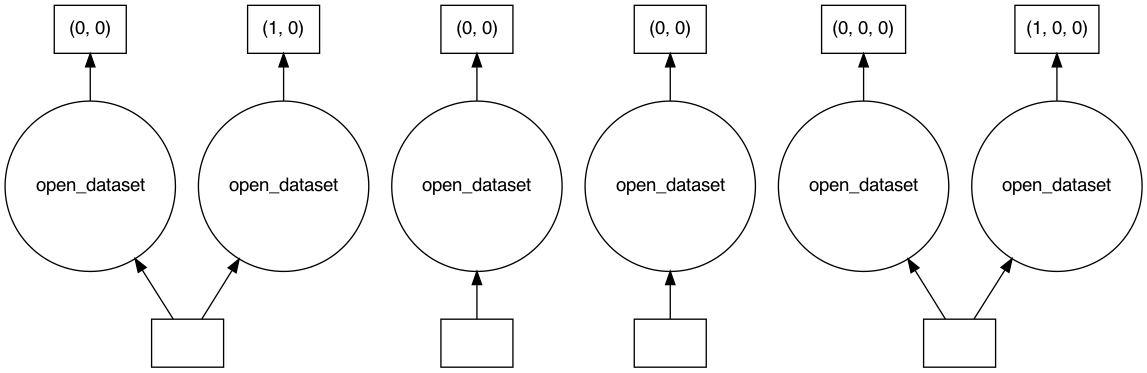

In [33]:
dask.visualize(ds)

### Parallel and Lazy computation using `dask.array` with xarray


Xarray seamlessly wraps dask so all computation is deferred until explicitly requested. 

In [34]:
z = ds.tos.mean(['lat', 'lon']).dot(ds.tos.T)
z

<xarray.DataArray 'tos' (lon: 360, lat: 180)>
dask.array<sum-aggregate, shape=(360, 180), dtype=float32, chunksize=(360, 180), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

As you can see, `z` contains a dask array. This is true for all xarray built-in operations including subsetting

In [35]:
z.isel(lat=0)

<xarray.DataArray 'tos' (lon: 360)>
dask.array<getitem, shape=(360,), dtype=float32, chunksize=(360,), chunktype=numpy.ndarray>
Coordinates:
    lat      float64 -89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

We can visualize this subset too!

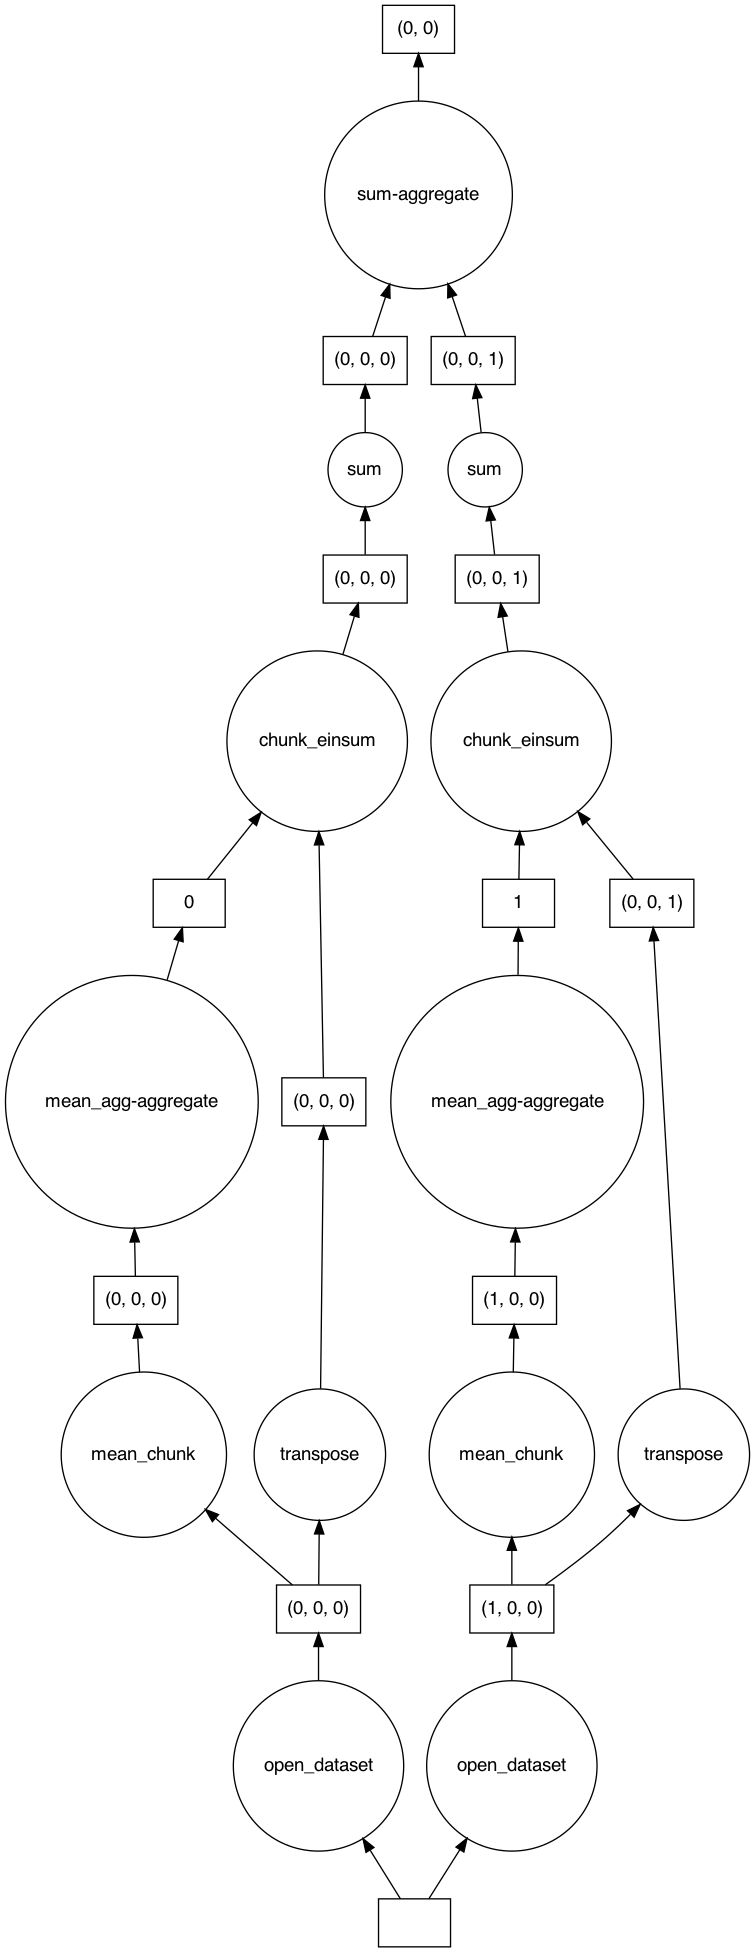

In [36]:
dask.visualize(z)

Now that we have prepared our calculation, we can go ahead and call `.compute()`

In [37]:
%%time
z.compute()

CPU times: user 16.7 ms, sys: 11.4 ms, total: 28.1 ms
Wall time: 243 ms


<xarray.DataArray 'tos' (lon: 360, lat: 180)>
array([[       nan,        nan,        nan, ..., -4365.4443, -4358.2935,
        -4350.544 ],
       [       nan,        nan,        nan, ..., -4365.45  , -4358.2417,
        -4350.411 ],
       [       nan,        nan,        nan, ..., -4365.458 , -4358.174 ,
        -4350.2705],
       ...,
       [       nan,        nan,        nan, ..., -4365.3965, -4358.381 ,
        -4350.911 ],
       [       nan,        nan,        nan, ..., -4365.4136, -4358.364 ,
        -4350.7944],
       [       nan,        nan,        nan, ..., -4365.429 , -4358.3354,
        -4350.673 ]], dtype=float32)
Coordinates:
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

## Spin Down the Cluster

In [39]:
cluster.close()
client.close()

---

## Summary

Dask Array does not implement the entire numpy interface.  Users expecting this
will be disappointed.  Notably Dask Array has the following failings:

1.  Dask Array does not support some operations where the resulting shape
    depends on the values of the array. For those that it does support
    (for example, masking one Dask Array with another boolean mask),
    the chunk sizes will be unknown, which may cause issues with other
    operations that need to know the chunk sizes.
2.  Dask Array does not attempt operations like ``sort`` which are notoriously
    difficult to do in parallel and are of somewhat diminished value on very
    large data (you rarely actually need a full sort).
    Often we include parallel-friendly alternatives like ``topk``.
3.  Dask development is driven by immediate need, and so many lesser used
    functions, like ``np.sometrue`` have not been implemented purely out of
    laziness.  These would make excellent community contributions.
    
We also saw that we can use `Xarray` to access `dask.arrays`, which required passing a `chunks` argument to upon opening the dataset. Once the data were loaded into Xarray, we can interact with the `xarray.Datasets` and `xarray.DataArrays` as we would if we working with `dask.arrays`. This can be a powerful tool when working with these datasets!

## Learn More

Visit the [Array documentation](https://docs.dask.org/en/latest/array.html). In particular, this [array screencast](https://youtu.be/9h_61hXCDuI) will reinforce the concepts you learned here.



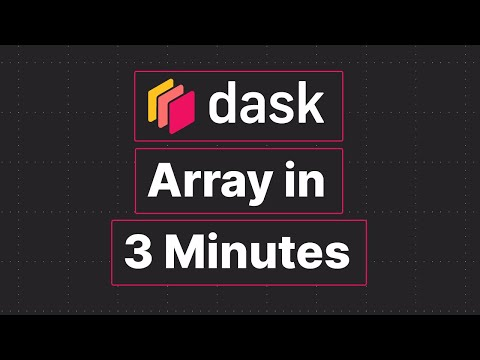

In [40]:
from IPython.display import YouTubeVideo

YouTubeVideo(id="9h_61hXCDuI", width=600, height=300)

## Resources and references

* Reference
    *  [Dask Docs](https://dask.org/)
    *  [Dask Examples](https://examples.dask.org/)
    *  [Dask Code](https://github.com/dask/dask/)
    *  [Dask Blog](https://blog.dask.org/)
    
    *  [Xarray Docs](https://xarray.pydata.org/)
  
*  Ask for help
    *   [`dask`](http://stackoverflow.com/questions/tagged/dask) tag on Stack Overflow, for usage questions
    *   [github discussions: dask](https://github.com/dask/dask/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: dask](https://github.com/dask/dask/issues/new) for bug reports and feature requests
     *   [github discussions: xarray](https://github.com/pydata/xarray/discussions) for general, non-bug, discussion, and usage questions
    *   [github issues: xarray](https://github.com/pydata/xarray/issues/new) for bug reports and feature requests
    
* Pieces of this notebook are adapted from the following sources
  * https://github.com/dask/dask-tutorial/blob/main/03_array.ipynb
  * https://github.com/xarray-contrib/xarray-tutorial/blob/master/scipy-tutorial/06_xarray_and_dask.ipynb